From last week I had a few nicely overfitting models, so I just keep that one and I will try some of the regularizations.

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import os
import random

FOLDER = "fashion-mnist"
theSIZE = (28, 28)
theLENGTH = 28*28

# will be non-empty if we are in the directory already
if os.path.exists(FOLDER):
    os.chdir(FOLDER)
elif os.getcwd().split('/')[-1] != FOLDER:
    print("The dataset is not in the current directory, cloning git repo...")
    os.system("git clone https://github.com/zalandoresearch/fashion-mnist")
    os.chdir(FOLDER)

from utils import mnist_reader

x_train, y_train = mnist_reader.load_mnist('data/fashion', kind='train')
x_test, y_test = mnist_reader.load_mnist('data/fashion', kind='t10k')

/usr/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
print(x_train.dtype)

(60000, 784) (10000, 784) (60000,) (10000,)
uint8


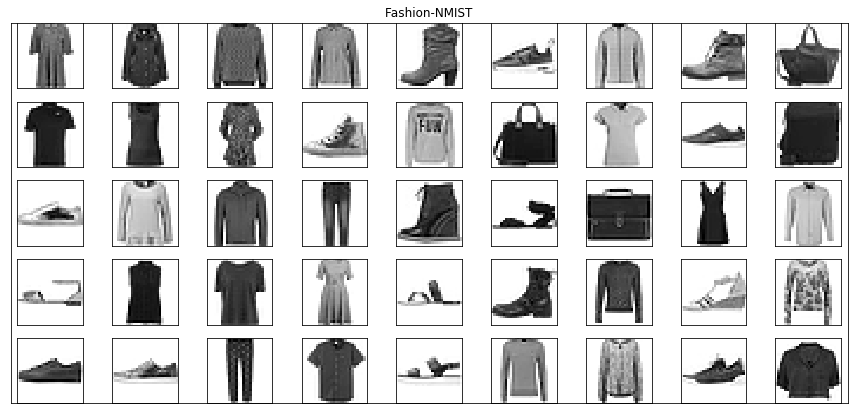

In [3]:
def show_imgs(images, columns=9, figsize=(15,7), title=''):
    fig=plt.figure(figsize=figsize)
    f = plt.title(title)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    rows = np.ceil(len(images)/columns).astype('int')
    for i in range(1, len(images)+1):
        fig.add_subplot(rows, columns, i)
        f = plt.imshow(images[i-1], cmap=plt.cm.binary)
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
    plt.show()
    
show_imgs([random.choice(x_train).reshape(theSIZE) for i in range(45)], title='Fashion-NMIST')

The dataset comes in nicely shuffled and the pictures are already representet by vectors, they are not normalized though...

In [4]:
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [6]:
def plot_history(history, figsize=(15,4), title='', columns=2, start_x_from=0):
    if hasattr(history, 'history'): # full history given
        history = history.history   # only that history is enough
        
    assert hasattr(history, 'keys')
    keys = [key for key in history.keys() if not key.startswith("val_")]
    assert keys # there is one at least
    epochs = list(range(1,len(history[keys[0]])+1)) # all should have the same size list
    
    rows = np.ceil(len(keys)/columns).astype('int')
    
    fig=plt.figure(figsize=figsize)
    f = plt.title(title)
    f.axes.get_xaxis().set_visible(False)
    f.axes.get_yaxis().set_visible(False)
    
    i = 1
    for key in sorted(keys):
        valkey = "val_" + key
        fig.add_subplot(rows, columns, i)
        i += 1
        plt.plot(epochs[start_x_from:], history[key][start_x_from:], 'bo', label="Training " + key)
        if valkey in history:
            plt.plot(epochs[start_x_from:], history[valkey][start_x_from:], 'r+', label='Validation ' + key)
        plt.legend()
        
    plt.show()

In [7]:
def build_model(*layers, verbose=False,
               optimizer='adam', loss='categorical_crossentropy', metrics=['acc'],
               compile_kwargs={}):
    
    model = keras.models.Sequential()
    for layer in layers:
        dropout = 0
        if 'dropout' in layer:
            dropout = layer.pop('dropout')
        model.add(keras.layers.Dense(**layer))
        if dropout:
            model.add(keras.layers.Dropout(dropout))
        
    if verbose:
        print("Model summary:")
        model.summary()
    
    for kw in ('optimizer', 'loss', 'metrics'):
        if not kw in compile_kwargs:
            compile_kwargs[kw] = locals()[kw]
    model.compile(**compile_kwargs)
    
    return model

That would be it for some helper functions and initialization...

Here are the regulations I will be trying in the beginning (and combinations between L1/L2 regularizations and dropout layers):

In [8]:
kernel_regs = (
    ('', {}),
    ('L1 regularization (0.01)' ,      {'kernel_regularizer': keras.regularizers.l1( 0.01)}),
    ('L1 regularization (0.001)',      {'kernel_regularizer': keras.regularizers.l1(0.001)}),
    ('L2 regularization (0.01)' ,      {'kernel_regularizer': keras.regularizers.l2( 0.01)}),
    ('L2 regularization (0.001)',      {'kernel_regularizer': keras.regularizers.l2(0.001)}),
    ('L1 & L2 regularization (0.01)' , {'kernel_regularizer': keras.regularizers.l1_l2(l1=0.01, l2=0.01)}),
    ('L1 & L2 regularization (0.001)', {'kernel_regularizer': keras.regularizers.l1_l2(l1=0.001, l2=0.001)})
)
dropouts = (
    ('', {}),
    ('Dropout layer (0.3)',            {'dropout'           : 0.3}),
    ('Dropout layer (0.5)',            {'dropout'           : 0.5})
)

def glue_names(n1, n2):
    if n1 and n2:
        return '{} + {}'.format(n1, n2)
    elif n1:
        return n1
    elif n2:
        return n2
    else:
        return "No regularization"
    
from itertools import product
regulz = [(glue_names(n1, n2), {**d1, **d2}) for (n1, d1), (n2, d2) in product(kernel_regs, dropouts)]

In [9]:
histories = {}
for title, kwargs in regulz:
    print('Processing:', title)
    model = build_model(
        dict(units=128, activation='relu', **kwargs, input_shape=x_train[0].shape),
        dict(units=128, activation='relu', **kwargs),
        dict(units= 64, activation='relu', **kwargs),
        dict(units= 32, activation='relu', **kwargs),
        dict(units= 10, activation='softmax')
    )
    hist = model.fit(x_train, y_train, epochs=500, batch_size=300, validation_data=(x_test,y_test), verbose=0)
    histories[title] = hist

Processing: No regularization
Processing: Dropout layer (0.3)
Processing: Dropout layer (0.5)
Processing: L1 regularization (0.01)
Processing: L1 regularization (0.01) + Dropout layer (0.3)
Processing: L1 regularization (0.01) + Dropout layer (0.5)
Processing: L1 regularization (0.001)
Processing: L1 regularization (0.001) + Dropout layer (0.3)
Processing: L1 regularization (0.001) + Dropout layer (0.5)
Processing: L2 regularization (0.01)
Processing: L2 regularization (0.01) + Dropout layer (0.3)
Processing: L2 regularization (0.01) + Dropout layer (0.5)
Processing: L2 regularization (0.001)
Processing: L2 regularization (0.001) + Dropout layer (0.3)
Processing: L2 regularization (0.001) + Dropout layer (0.5)
Processing: L1 & L2 regularization (0.01)
Processing: L1 & L2 regularization (0.01) + Dropout layer (0.3)
Processing: L1 & L2 regularization (0.01) + Dropout layer (0.5)
Processing: L1 & L2 regularization (0.001)
Processing: L1 & L2 regularization (0.001) + Dropout layer (0.3)
Pr

After about 5 hours we have the results!

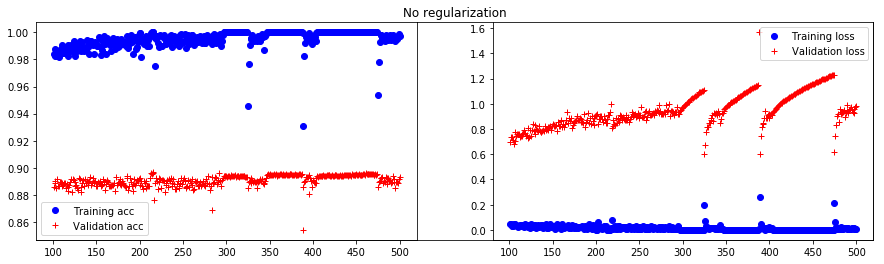

	Final accuracy is 0.8930 and final loss 0.9865


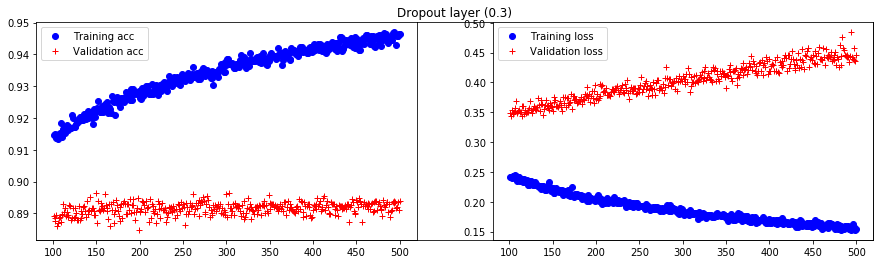

	Final accuracy is 0.8939 and final loss 0.4453


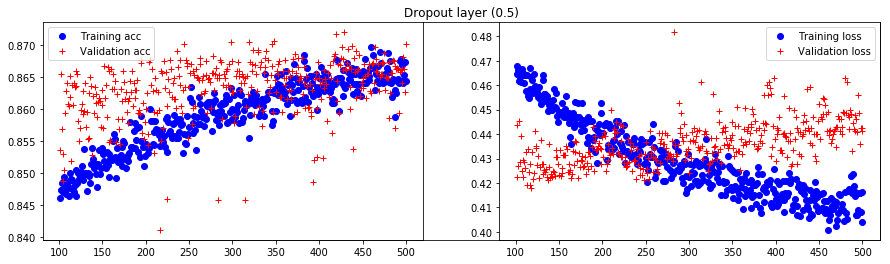

	Final accuracy is 0.8702 and final loss 0.4426


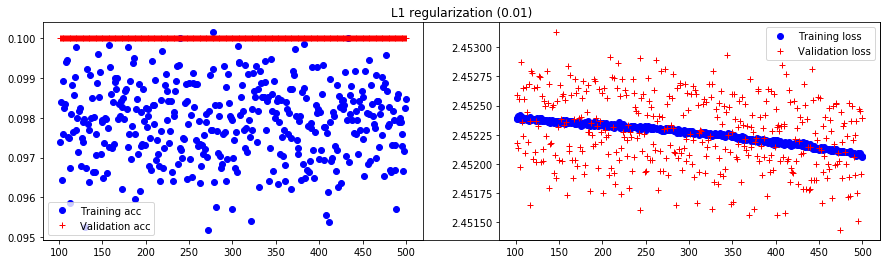

	Final accuracy is 0.1000 and final loss 2.4524


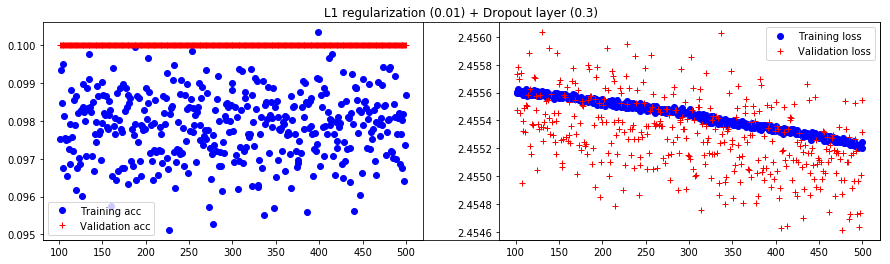

	Final accuracy is 0.1000 and final loss 2.4555


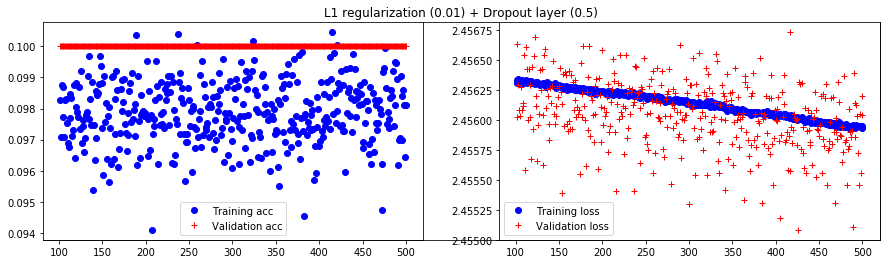

	Final accuracy is 0.1000 and final loss 2.4562


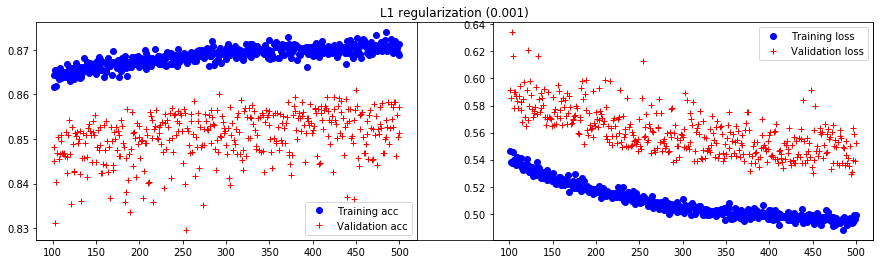

	Final accuracy is 0.8514 and final loss 0.5520


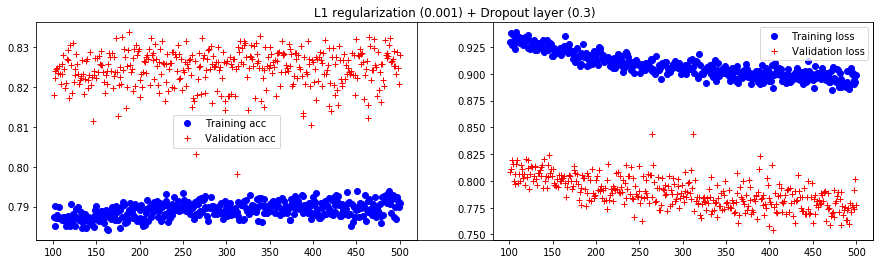

	Final accuracy is 0.8280 and final loss 0.7775


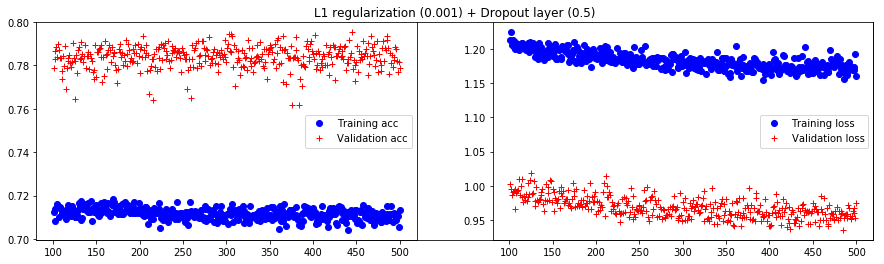

	Final accuracy is 0.7790 and final loss 0.9750


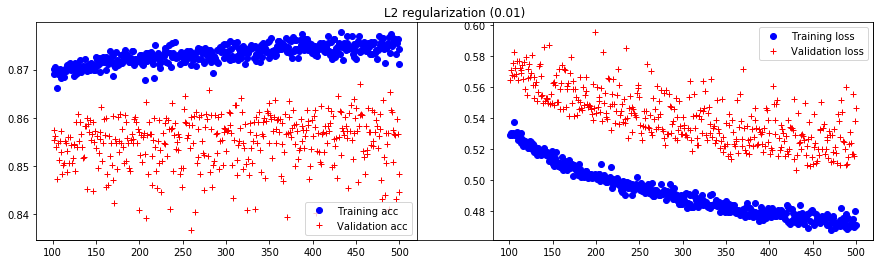

	Final accuracy is 0.8446 and final loss 0.5464


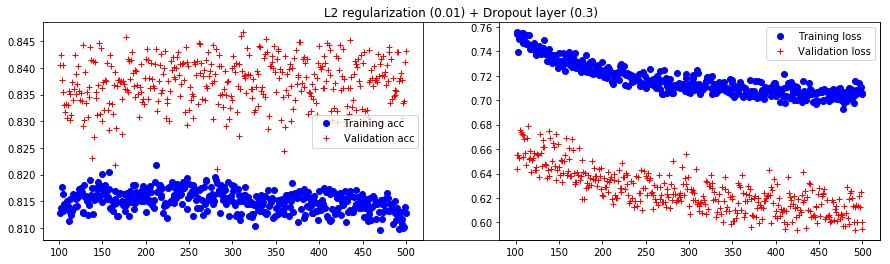

	Final accuracy is 0.8432 and final loss 0.5948


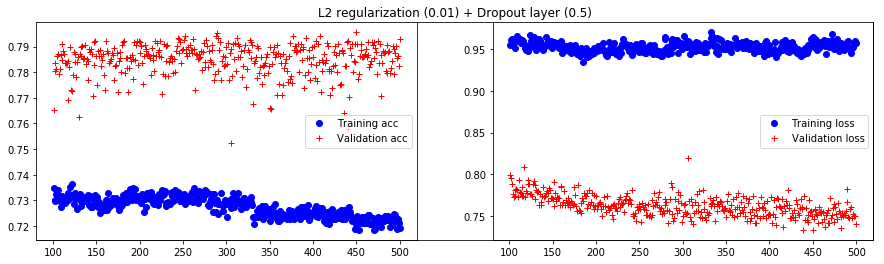

	Final accuracy is 0.7928 and final loss 0.7410


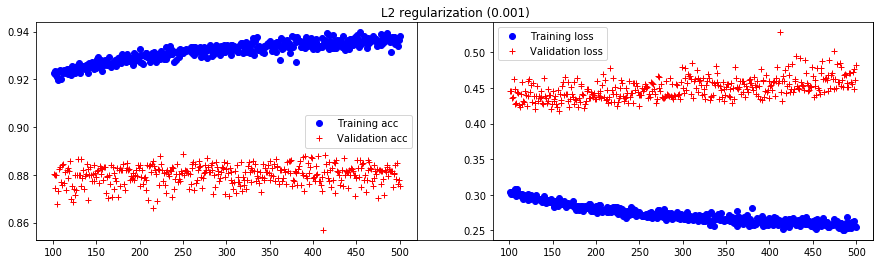

	Final accuracy is 0.8752 and final loss 0.4823


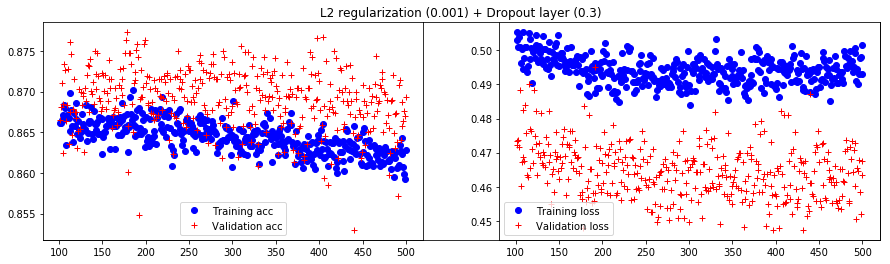

	Final accuracy is 0.8693 and final loss 0.4674


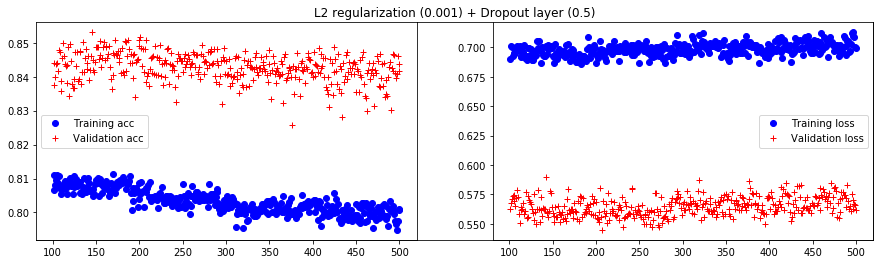

	Final accuracy is 0.8416 and final loss 0.5615


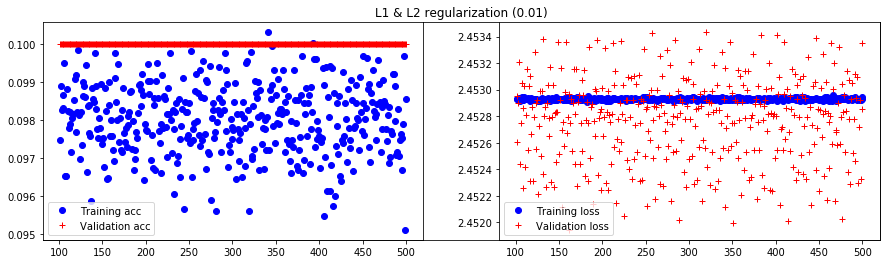

	Final accuracy is 0.1000 and final loss 2.4534


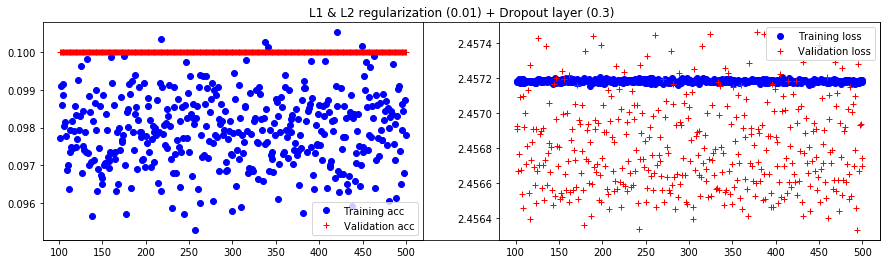

	Final accuracy is 0.1000 and final loss 2.4567


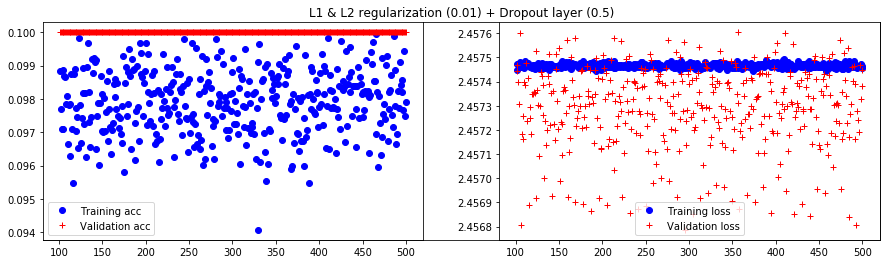

	Final accuracy is 0.1000 and final loss 2.4574


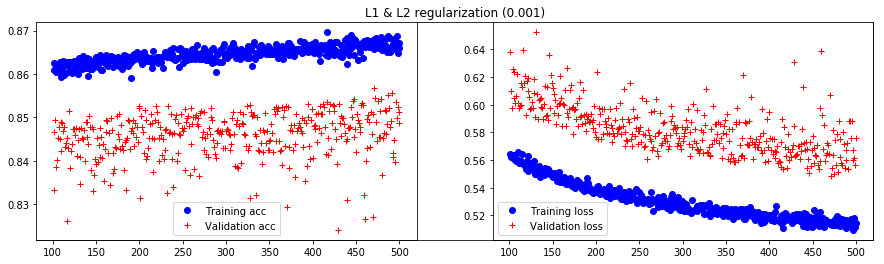

	Final accuracy is 0.8488 and final loss 0.5761


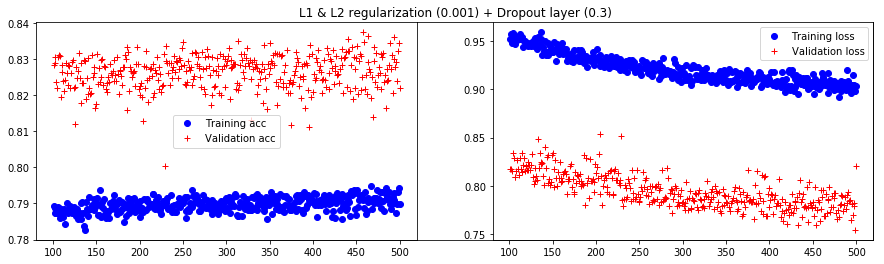

	Final accuracy is 0.8220 and final loss 0.8207


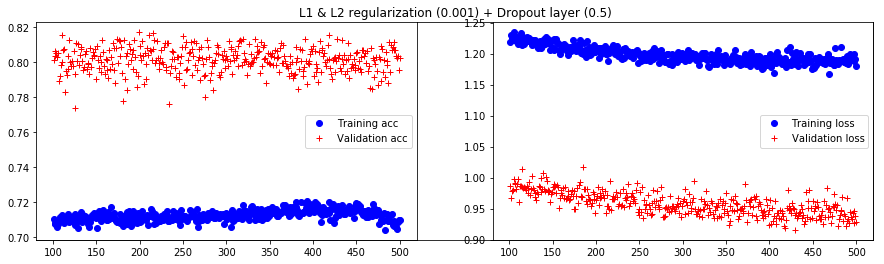

	Final accuracy is 0.8026 and final loss 0.9288


In [11]:
for title, hist in histories.items():
    plot_history(hist, title=title, start_x_from=100)
    print("\tFinal accuracy is {:0.4f} and final loss {:0.4f}".format(
        hist.history['val_acc'][-1], hist.history['val_loss'][-1]))

To my eye most of it seems disappointing... But it gave me an idea which methods might be prospective here. Perhaps there were just too few epochs.

(And what the plot does the 'No regularization' model have? It looks like it was teleporting around in the metrics, which momentarily brought some apparent generalization but then went away.)

Here a bit more compact representation:

In [15]:
for title, hist in histories.items():
    print("\tFinal accuracy is {:0.4f} and final loss {:0.4f}\t({})".format(
        np.mean(hist.history['val_acc'][-10:]),
        np.mean(hist.history['val_loss'][-10:]),
        title))

	Final accuracy is 0.8903 and final loss 0.9552	(No regularization)
	Final accuracy is 0.8928 and final loss 0.4463	(Dropout layer (0.3))
	Final accuracy is 0.8655 and final loss 0.4443	(Dropout layer (0.5))
	Final accuracy is 0.1000 and final loss 2.4521	(L1 regularization (0.01))
	Final accuracy is 0.1000 and final loss 2.4551	(L1 regularization (0.01) + Dropout layer (0.3))
	Final accuracy is 0.1000 and final loss 2.4559	(L1 regularization (0.01) + Dropout layer (0.5))
	Final accuracy is 0.8542 and final loss 0.5440	(L1 regularization (0.001))
	Final accuracy is 0.8259 and final loss 0.7781	(L1 regularization (0.001) + Dropout layer (0.3))
	Final accuracy is 0.7827 and final loss 0.9625	(L1 regularization (0.001) + Dropout layer (0.5))
	Final accuracy is 0.8535 and final loss 0.5284	(L2 regularization (0.01))
	Final accuracy is 0.8378 and final loss 0.6088	(L2 regularization (0.01) + Dropout layer (0.3))
	Final accuracy is 0.7868 and final loss 0.7508	(L2 regularization (0.01) + Dro

Training with 3 times more epochs:

In [17]:
histories2 = {}
for title, kwargs in (regulz[2], regulz[12], regulz[14]):
    print('Processing:', title)
    model = build_model(
        dict(units=128, activation='relu', **kwargs, input_shape=x_train[0].shape),
        dict(units=128, activation='relu', **kwargs),
        dict(units= 64, activation='relu', **kwargs),
        dict(units= 32, activation='relu', **kwargs),
        dict(units= 10, activation='softmax')
    )
    hist = model.fit(x_train, y_train, epochs=1500, batch_size=300, validation_data=(x_test,y_test), verbose=0)
    histories2[title] = hist

Processing: Dropout layer (0.5)
Processing: L2 regularization (0.001)
Processing: L2 regularization (0.001) + Dropout layer (0.5)


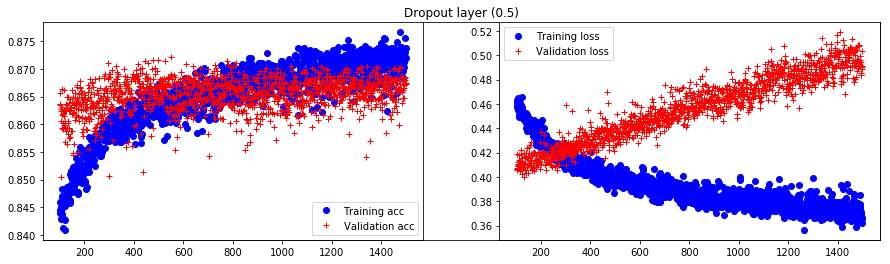

	Final accuracy is 0.8673 and final loss 0.4910	(Dropout layer (0.5))


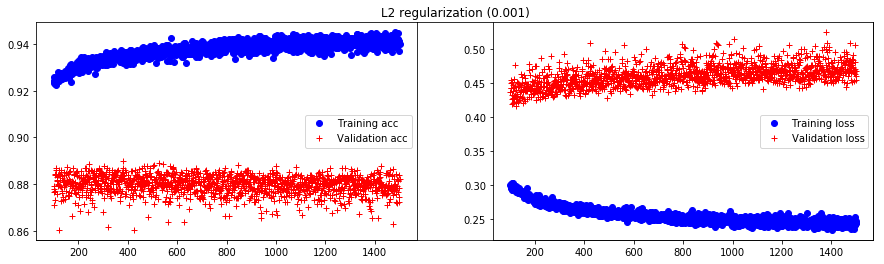

	Final accuracy is 0.8795 and final loss 0.4683	(L2 regularization (0.001))


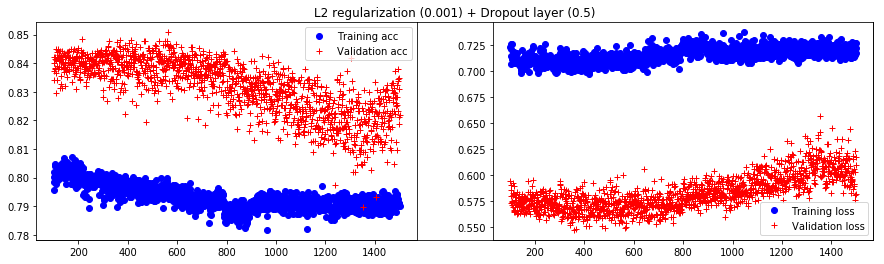

	Final accuracy is 0.8283 and final loss 0.5976	(L2 regularization (0.001) + Dropout layer (0.5))


In [19]:
for title, hist in histories2.items():
    plot_history(hist, title=title, start_x_from=100)
    print("\tFinal accuracy is {:0.4f} and final loss {:0.4f}\t({})".format(
        np.mean(hist.history['val_acc'][-10:]),
        np.mean(hist.history['val_loss'][-10:]),
        title))

Well, at least I have nice pictures, who cares about good results then? :)

Looks like I chose a wrong model as the approaches tend to even worsen the results compared to no regularization, unfortunatelly, I do not have enough time now to train new mmodels as it takes significant amount of time... At least I will ponder about some of the traits the results have. 